In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")

today = pd.to_datetime('today').date()


# Preproccesing

In [2]:
# dates chosen where no nan values are present (google starts from end of 2004)
def getData(ticker, start_date = '2020-01-01', end_date = today, interval = '1d'):
    data = yf.download(ticker, start=start_date, end=end_date, interval=interval)
    return data

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL',]

# generate df
df = pd.DataFrame()
for ticker in tickers:
    data = getData(ticker)
    data = data['Adj Close']
    data = data.rename(ticker)
    df = df.merge(data, how='outer', left_index=True, right_index=True)


df.tail()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,AAPL,MSFT,GOOGL
Date,,,
2024-06-27,214.100006,452.850006,185.410004
2024-06-28,210.619995,446.950012,182.149994
2024-07-01,216.750000,456.730011,182.990005
2024-07-02,220.270004,459.279999,185.240005
2024-07-03,221.550003,460.769989,185.820007


<Axes: xlabel='Date'>

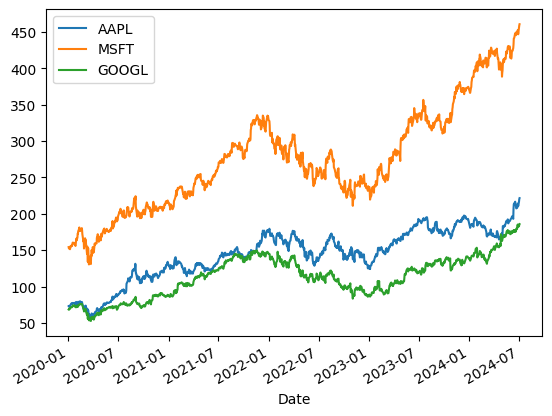

In [4]:
df.plot()

# ARIMA


ARIMA takes 3 parameters $(p,d,q)$ where:
- p is the number of autoregressive
- d is the degree of differencing
- q is the number of moving average terms

$Y_t=\alpha + \beta_1\cdot Y_{t-1} + \beta_{2}\cdot Y_{t-2} +\dots+ \beta_{p}\cdot Y_{t-p} \cdot \epsilon_{t} + \Phi_1\cdot\epsilon_{t-1} + \Phi_2\cdot\epsilon_{t-2} + \dots + \Phi_{q}\cdot\epsilon_{t-q}$\\
where:
- $Y_t$ is The predictor at time $t$
- $\alpha$ is the constant
- $\beta_{i}$'s are parameters
- $\epsilon_{i}$ are white noise error terms
- $\Phi_i$'s are parameters

### d
1. Check if data is stationery using the augmented dicky-fuller test
    - $H_0$ - data is not stationery
    - $H_1$ - data is stationery
    - If $P<0.05$ then we reject $H_0$ and data is stationery (which is a requirement of ARIMA)
2. If Data is not stationery we use differencing to make it stationery
    - Differencing is essentially taking a value and subtracting the value immediately preceding it
    - The resultant series will have n-1 values
    - it might be nessesary to difference multiple times so we keep doing it until the dataset is stationery
    - this number is d

### p
This is the AR term. Look at the PACF plot.
- Identify the lag at which the PACF cuts off
- The point at which the PACF plot cuts off indicates the number of AR terms (p).

### q
This is the MA term. Look at the ACF plot.
- Identify the lag at which the ACF cuts off.
- The point at which the ACF plot cuts off indicates the number of MA terms ( q ).



In [6]:
# 1
def is_stationary(series):
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(series)
    return result[1] < 0.05

# 2
def differencing(series):
    d=0
    while not is_stationary(series):
        series = series.diff().dropna()
        d+=1
    return series, d

def plot_acf(diff):
    from statsmodels.graphics.tsaplots import plot_acf
    print('ACF of differenced series')
    plot_acf(diff)
    plt.show()

def plot_pacf(diff):
    from statsmodels.graphics.tsaplots import plot_pacf
    print('PACF of differenced series')
    plot_pacf(diff)
    plt.show()


def get_parameters(series):
    # prepare stationary dataset
    series.plot()
    if not is_stationary(series):
        print('Data is not stationary. Differencing...')
        plt.show()
        diff, d = differencing(series)
        diff.plot()
        if is_stationary(diff):
            print('Data is now stationary. d =', d)
            plt.show()
            plot_pacf(diff)
            plot_acf(diff)

        else:
            print('given up')
            return

def arima_model(stock, param):
    model = ARIMA(df[stock], order = param)
    model_fit = model.fit()

    forecast = model_fit.forecast(steps=20)

    forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=20, freq='D')
    forecast.index = forecast_index

    combined_series = pd.concat([model_fit.fittedvalues, forecast])

    combined_series = combined_series.rename(stock+'_forcast')

    res = pd.concat([df[stock], combined_series], axis=1, keys=['original', 'forcast'])
    res['forcast'] = res['forcast'].shift(-param[1])
    res.dropna(how='all', inplace=True)


    return res, model_fit.summary()

ACF of differenced series


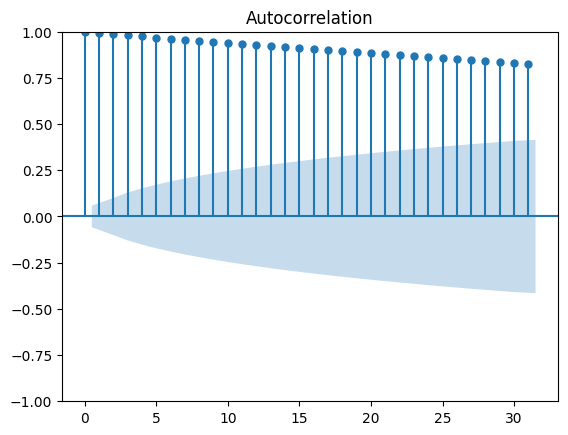

PACF of differenced series


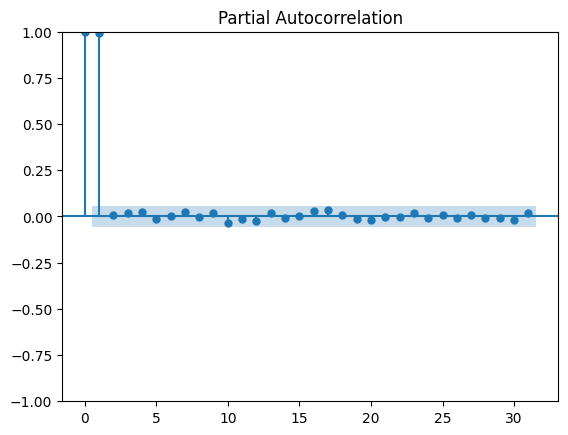

In [7]:
plot_acf(df['AAPL'])
plot_pacf(df['AAPL'])

## APPLE

Data is not stationary. Differencing...


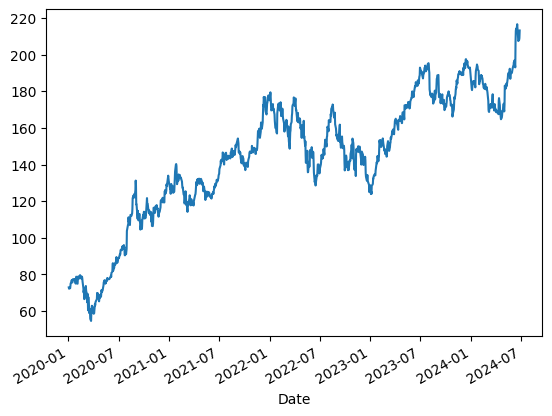

Data is now stationary. d = 1


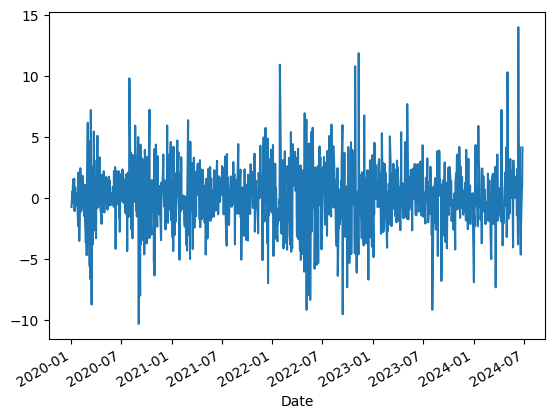

PACF of differenced series


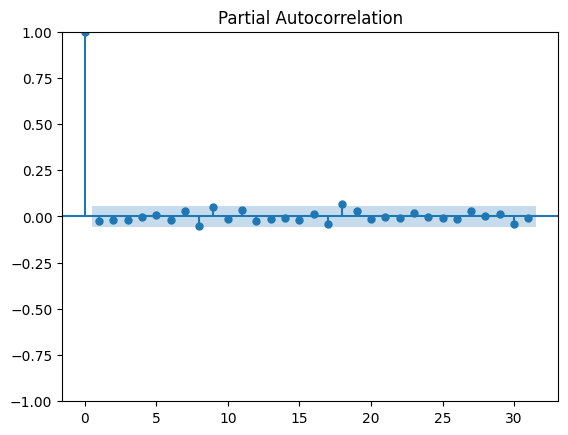

ACF of differenced series


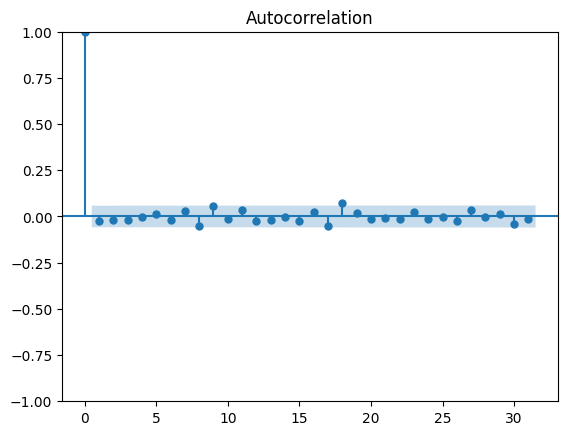

In [ ]:
get_parameters(df['AAPL'])

p=1
- PACF drops off after 1 lag

d=1
- First order differencing is enough

q=1
- ACF drops off after 1 lag

,original,forcast
2024-07-06,NaN,213.023432
2024-07-07,NaN,213.023329
2024-07-08,NaN,213.023275
2024-07-09,NaN,213.023246
2024-07-10,NaN,213.023231
2024-07-11,NaN,213.023223
2024-07-12,NaN,213.023218
2024-07-13,NaN,213.023216
2024-07-14,NaN,213.023215
2024-07-15,NaN,213.023214


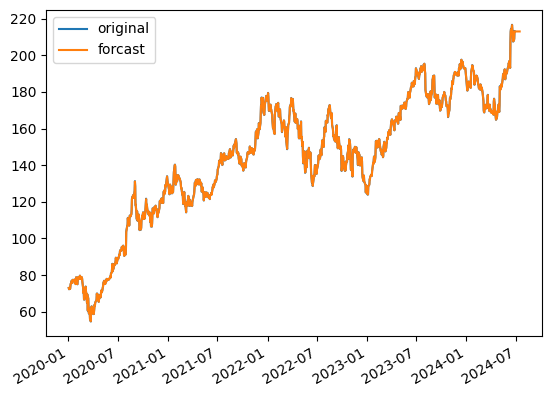

In [ ]:
aapl, aapl_summary = arima_model('AAPL', (1,1,1))
aapl.plot()
aapl.tail(10)

## MICROSOFT

Data is not stationary. Differencing...


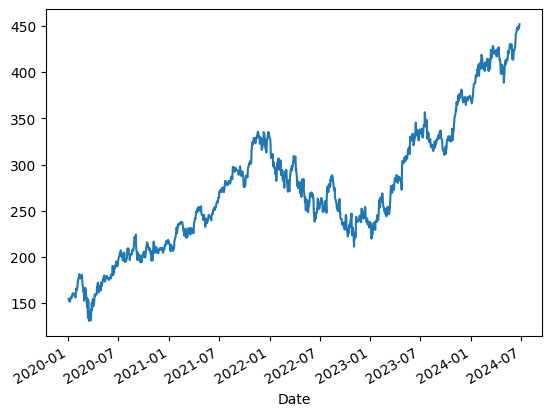

Data is now stationary. d = 1


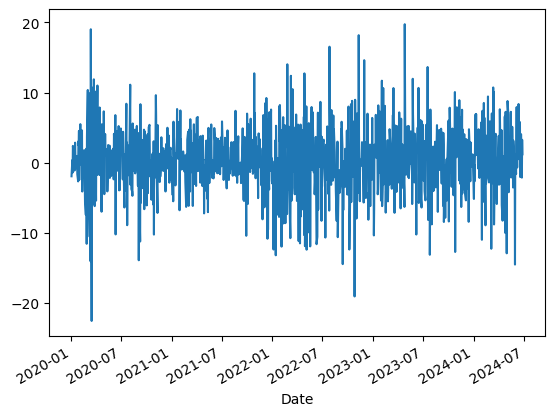

PACF of differenced series


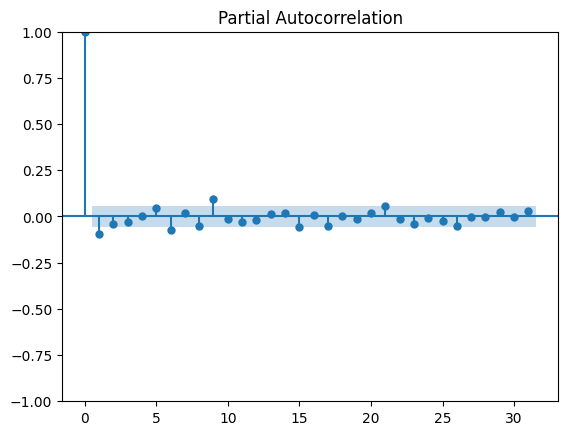

ACF of differenced series


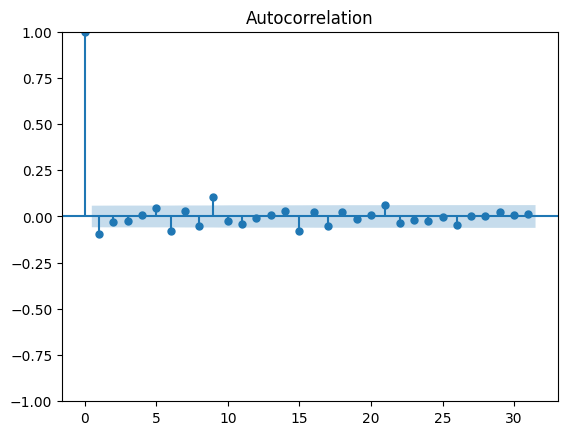

In [ ]:
get_parameters(df['MSFT'])

p=1
- PACF drops off after 1 lag

d=1
- First order differencing is enough

q=1
- ACF drops off after 1 lag

,original,forcast
2024-06-11,432.679993,432.054364
2024-06-12,441.059998,440.008349
2024-06-13,441.579987,441.134039
2024-06-14,442.570007,442.305928
2024-06-17,448.369995,447.705622
2024-06-18,446.339996,446.288068
2024-06-20,445.700012,445.742850
2024-06-21,449.779999,449.398573
2024-06-24,447.670013,447.732230
2024-06-25,450.950012,450.653816


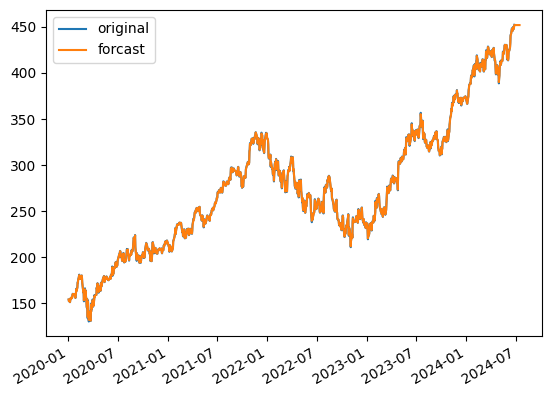

In [ ]:
msft, msft_summary = arima_model('MSFT', (1,1,1))
msft.plot()
msft.tail(30)

## GOOGLE

Data is not stationary. Differencing...


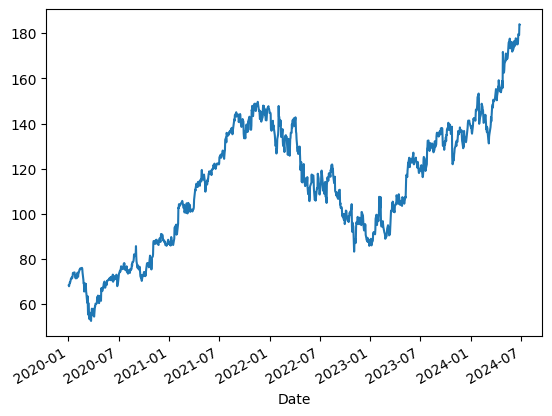

Data is now stationary. d = 1


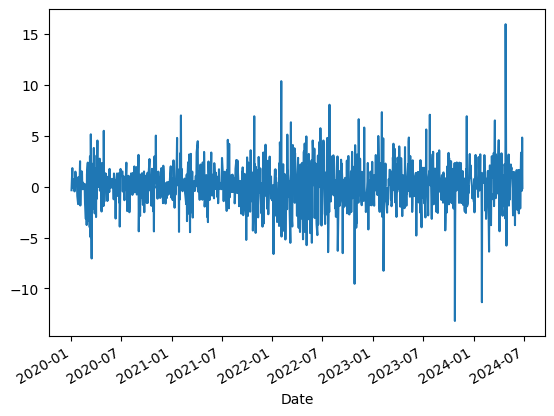

PACF of differenced series


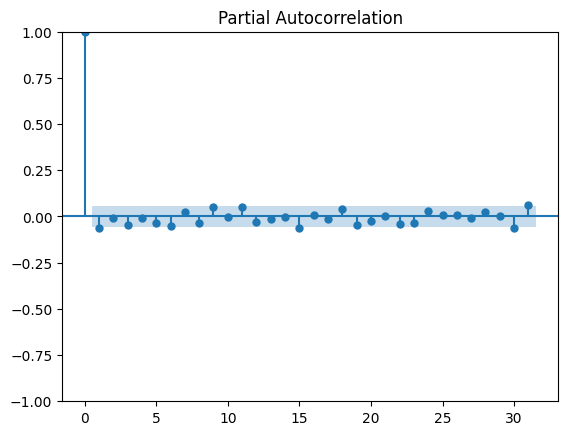

ACF of differenced series


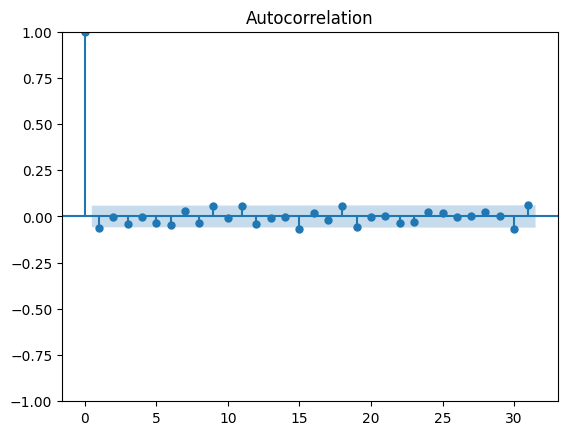

In [ ]:
get_parameters(df['GOOGL'])

,original,forcast
2024-07-06,NaN,183.202927
2024-07-07,NaN,183.200588
2024-07-08,NaN,183.199050
2024-07-09,NaN,183.198038
2024-07-10,NaN,183.197372
2024-07-11,NaN,183.196934
2024-07-12,NaN,183.196645
2024-07-13,NaN,183.196456
2024-07-14,NaN,183.196331
2024-07-15,NaN,183.196249


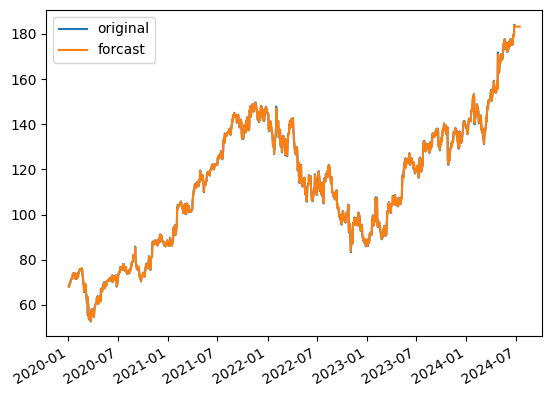

In [ ]:
googl, googl_summary = arima_model('GOOGL', (1,1,1))
googl.plot()
googl.tail(10)